# Slab energy

前節では結晶構造 (bulk) を取り扱いました。

5章などで後述するように、触媒上での反応解析を行う場合などは、触媒金属表面上で有機分子が反応する過程などを扱いますが、
そのためには物質の表面での構造を取り扱う必要があります。

本節では、表面構造 (本Tutorialでは、Slab構造と記述します)に関係するエネルギーとして、以下を取り扱います。

 - 表面エネルギー
 - 界面エネルギー

In [1]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="latest")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.18.0


## 表面エネルギー

表面エネルギーは、ある結晶構造が表面を作るために必要なエネルギーで、以下のように単位面積あたりのエネルギーとして定義されます。

$$ E_{\rm{surface}} = \frac{E_{\rm{slab}} - E_{\rm{bulk}}}{2A}$$

$E_{\rm{surface}}$が表面エネルギー、$E_{\rm{slab}}$が以下で説明する表面モデルのエネルギー、$E_{\rm{bulk}}$は結晶のエネルギーで、$A$は上下面の表面積です。

### Pt111面の表面エネルギー

具体例で見ていきましょう。FCC構造を持つPt金属の111面の表面エネルギーを求めて見ます。<br/>
まずは、結晶構造とSlab構造 (表面モデル) の違いについての説明を行います。

In [2]:
from ase.build import bulk, fcc111
from pfcc_extras.visualize.view import view_ngl


atoms_bulk = bulk("Pt", cubic=True) * (4, 4, 6)
atoms_slab = fcc111("Pt", size=(4, 4, 6), vacuum=10.0, orthogonal=True, periodic=True)
atoms_slab.pbc

array([ True,  True,  True])

以下の図のように結晶構造は３次元方向に周期境界条件が続くもので、Slab (表面構造)はxy平面の2方向のみに周期境界条件が続きつつもz方向には表面が切り出されているものです。

ただしDFT計算などで周期境界条件を扱う際、3方向全てに対して周期境界条件を課す必要があるため、モデリング上はz軸方向に"十分に大きい"セルサイズをとることで擬似的に表面構造を表します。<br/>
z軸方向のセルサイズとして必要な大きさは選択する力場に依存します。z軸の上下の原子の相互作用の影響が無視できるレベルまで離します。<br/>
今回使用しているPFPの場合はcutoff半径は6Aのため、真空層 (以下では`vaccum`で指定)を6A 以上の大きさに取ればよいです。<br/>
DFTなどの量子化学計算を用いる場合には真空層が大きくなると計算時間も長くなってしまうこともあるため、適切な大きさを選択する必要があります。

※ `fcc111`関数で生成する際に `periodic=True` としていますが、これをいれないと周期境界条件は `pbc=[True, True, False]` とxy平面のみに課された状態となります。ここでは明示的に真空層を`vacuum`で指定して設定した上で3次元方向全てに周期境界が課されるようにしています。

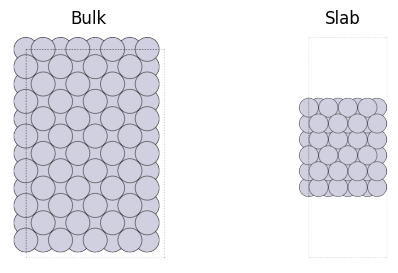

In [3]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

write("output/pt_bulk.png", atoms_bulk, rotation="90x,0y,0z")
write("output/pt_slab.png", atoms_slab, rotation="90x,0y,0z")


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax0, ax1 = axes
ax0.imshow(mpimg.imread("output/pt_bulk.png"))
ax0.set_axis_off()
ax0.set_title("Bulk")
ax1.imshow(mpimg.imread("output/pt_slab.png"))
ax1.set_axis_off()
ax1.set_title("Slab")
fig.show()

#### 表面のモデリングについて

表面というのはBulk内部とは全く違う状態となっています。
これは[配位数](https://ja.wikipedia.org/wiki/%E9%85%8D%E4%BD%8D%E6%95%B0) (各原子の周りにいる原子の数)をみるだけでも大きく異なっている事がわかります。
結果として表面は全体的に不安定な状態になっています。

表面構造を作成する時は、十分な厚みを取る必要があります。今回の例では z軸方向に6層取られています。<br/>
これは、安定であるBulkの状態から、不安定になる表面状態への移り変わりが十分に表現できるだけの厚みが必要で、<br/>
本Tutorialでは4-6層程度以上の厚みを取ることをオススメします。

厚みは大きいほうが現実に近いモデリングとなりますが、量子化学計算を行う際は計算時間による制限があるので4層程度が使われていることが多いです。

xy方向は、周期境界条件があるため無限に続くような構造となっています。<br/>
後述する吸着構造などではxy方向にもスーパーセルを十分に大きく取る必要がありますが、表面エネルギーの場合は小さくても良いでしょう。

In [4]:
view_ngl([atoms_slab, atoms_bulk], replace_structure=True)

まずは結晶構造の構造最適化を行い `E_bulk` を求めます。

In [5]:
symbol = "Pt"
atoms_bulk = bulk(symbol, "fcc")
atoms_bulk.calc = calculator
atoms_bulk_strain = StrainFilter(atoms_bulk, mask=[1, 1, 1, 0, 0, 0])
opt = LBFGS(atoms_bulk_strain)
#opt = BFGS(atoms_bulk_strain)
opt.run(fmax=0.001)
E_bulk = atoms_bulk.get_total_energy()
print(f"E_bulk = {E_bulk} eV")

       Step     Time          Energy          fmax
LBFGS:    0 14:20:03       -5.437334        1.533896
LBFGS:    1 14:20:03       -5.452856        0.064256
LBFGS:    2 14:20:03       -5.452887        0.005071


/tmp/ipykernel_2267/2836453991.py:4: FutureWarning: Import StrainFilter from ase.filters
  atoms_bulk_strain = StrainFilter(atoms_bulk, mask=[1, 1, 1, 0, 0, 0])


LBFGS:    3 14:20:03       -5.452885        0.000001
E_bulk = -5.45288541378143 eV


次に、Slab構造を作成し、構造最適化を行って `E_slab`を求めます。

このとき、Slab構造のセルサイズは**Bulk構造の構造最適化結果で得られたサイズで固定します**。
構造最適化では**座標値のみ**を最適化します。

理由として、Slab構造はモデリングのため小さな構造となっていますが、実際は無限に大きなBulk構造に対する表面を考えたいため、その際のx, y 方向に対するセルサイズは結晶のままであると考えられるためです。

In [6]:
a = atoms_bulk.cell[0, 2] * 2
atoms_slab = fcc111("Pt", size=(4, 4, 8), a=a, vacuum=40.0, periodic=True)
atoms_slab.calc = calculator
# atoms_slab_strain = ExpCellFilter(atoms_slab)
atoms_slab_strain = atoms_slab
opt = LBFGS(atoms_slab_strain)
#opt = BFGS(atoms_slab_strain)
opt.run(fmax=0.001)
E_slab = atoms_slab.get_total_energy()
print(f"E_slab = {E_slab} eV")

       Step     Time          Energy          fmax
LBFGS:    0 14:20:04     -678.318473        0.188715
LBFGS:    1 14:20:04     -678.342291        0.142895
LBFGS:    2 14:20:04     -678.375084        0.029011
LBFGS:    3 14:20:04     -678.375773        0.019673
LBFGS:    4 14:20:04     -678.376585        0.009009
LBFGS:    5 14:20:04     -678.376605        0.008281
LBFGS:    6 14:20:04     -678.377034        0.008756
LBFGS:    7 14:20:04     -678.377095        0.008394
LBFGS:    8 14:20:04     -678.377116        0.007696
LBFGS:    9 14:20:04     -678.377310        0.011896
LBFGS:   10 14:20:04     -678.377607        0.013935
LBFGS:   11 14:20:04     -678.377877        0.009423
LBFGS:   12 14:20:04     -678.377945        0.002772
LBFGS:   13 14:20:04     -678.377859        0.000256
E_slab = -678.3778592029213 eV


これで、`E_bulk`, `E_slab` が得られました。

Slab構造の表面積 $A$ は以下のように求めることができます。

In [7]:
import numpy as np

cx, cy, cz = atoms_slab.cell
print("Cell length = ", cx, cy, cz)
A = np.linalg.norm(np.cross(cx, cy))

print(f"Area A = {A:.2f} A^2")

Cell length =  [11.22158247  0.          0.        ] [5.61079123 9.71817549 0.        ] [ 0.         0.        96.0341715]
Area A = 109.05 A^2


最後に、表面エネルギー $E_{\rm{surface}}$ は以下のように求まります。分母が $2*A$ となっているのはｚ軸上下それぞれで２つ表面が存在するためです。

In [8]:
E_surface = (E_slab - E_bulk * len(atoms_slab) / len(atoms_bulk)) / (2 * A)
print(f"E_surface = {E_surface:.3f} eV/A^2")

E_surface = 0.090 eV/A^2


### 様々な金属111面の表面エネルギー

上記計算を様々な金属原子に対して行ってみましょう。

In [9]:
from ase.optimize import BFGS

def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    if opt_mode == "scale":
        opt = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]), logfile=None)
    elif opt_mode == "all":
        opt = LBFGS(UnitCellFilter(atoms), logfile=None)
    else:
        opt = LBFGS(atoms, logfile=None)
    opt.run(fmax=fmax)
    return atoms.get_total_energy()


def calc_fcc111_surface_energy(calculator, symbol: str = "Pt", size=(2, 4, 4)):
    atoms_bulk = bulk(symbol, "fcc")
    atoms_bulk.calc = calculator
    E_bulk = get_opt_energy(atoms_bulk, fmax=0.001, opt_mode="scale")
    a = atoms_bulk.cell[0, 2] * 2
    
    # Default pbc is [True, True, False] (not periodic on z-axis). But this is not supported in PFP so set all pbc=True.
    slab = fcc111(symbol, size=size, a=a, vacuum=40.0, periodic=True)
    slab.calc = calculator
    E_slab = get_opt_energy(slab, fmax=0.001)

    # calc area of slab on xy plane
    cx, cy, cz = slab.cell
    A = np.linalg.norm(np.cross(cx, cy))
    N = len(slab)
    E_surface = (E_slab - E_bulk * N) / (2 * A)  # unit (ev/A^2)
    print(f"E_slab {E_slab:.3f} eV, E_bulk {E_bulk:.3f} eV, E_surface {E_surface:.3f} eV/A^2, A {A} A^2, N {N}")
    return E_surface

PFPを用いる場合は計算時間が高速なため、以下ではz軸方向に8層の厚みをとって計算しています。

In [10]:
E_surface_list = []
for symbol in ["Al", "Cu", "Rh", "Pd", "Ag", "Pt", "Au"]:
    E_surface = calc_fcc111_surface_energy(calculator, symbol, size=(4, 4, 8))
    print(f"{symbol} E_surface = {E_surface:.3f} eV/A^2")
    E_surface_list.append({"symbol": symbol, "E_surface[eV/A^2]": E_surface})

/tmp/ipykernel_2267/1216418715.py:5: FutureWarning: Import StrainFilter from ase.filters
  opt = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]), logfile=None)


E_slab -426.284 eV, E_bulk -3.422 eV, E_surface 0.052 eV/A^2, A 113.36914123786667 A^2, N 128
Al E_surface = 0.052 eV/A^2
E_slab -434.149 eV, E_bulk -3.508 eV, E_surface 0.081 eV/A^2, A 91.39550934476856 A^2, N 128
Cu E_surface = 0.081 eV/A^2
E_slab -709.922 eV, E_bulk -5.756 eV, E_surface 0.132 eV/A^2, A 101.58056423746542 A^2, N 128
Rh E_surface = 0.132 eV/A^2
E_slab -459.258 eV, E_bulk -3.731 eV, E_surface 0.085 eV/A^2, A 107.62878995118758 A^2, N 128
Pd E_surface = 0.085 eV/A^2
E_slab -310.732 eV, E_bulk -2.510 eV, E_surface 0.044 eV/A^2, A 119.3239282367077 A^2, N 128
Ag E_surface = 0.044 eV/A^2
E_slab -678.378 eV, E_bulk -5.453 eV, E_surface 0.090 eV/A^2, A 109.05331348779089 A^2, N 128
Pt E_surface = 0.090 eV/A^2
E_slab -376.955 eV, E_bulk -3.028 eV, E_surface 0.044 eV/A^2, A 119.78247470664611 A^2, N 128
Au E_surface = 0.044 eV/A^2


In [11]:
import pandas as pd
df = pd.DataFrame(E_surface_list)
df

,symbol,E_surface[eV/A^2]
0,Al,0.051554
1,Cu,0.081404
2,Rh,0.132156
3,Pd,0.085161
4,Ag,0.043968
5,Pt,0.089825
6,Au,0.044478


上記のように様々な元素の表面エネルギーを求めることができました。単位を変換したい場合、たとえば eV/A^2 から J/m^2 へは以下のように計算できます。

In [12]:
from ase.units import J

# 1 Angstrom = 10^-10 meter
meter = 10 ** 10
ratio = J/(meter ** 2)
df["E_surface[J/m^2]"] = df["E_surface[eV/A^2]"] / ratio
df

,symbol,E_surface[eV/A^2],E_surface[J/m^2]
0,Al,0.051554,0.825992
1,Cu,0.081404,1.304239
2,Rh,0.132156,2.117379
3,Pd,0.085161,1.364426
4,Ag,0.043968,0.704451
5,Pt,0.089825,1.439160
6,Au,0.044478,0.712611


以下文献では、Cu 0.080, Pt 0.084, Au 0.050 eV/A^2 と報告されており、近い値が得られていることがわかります。

 - [Relaxation and reconstruction on (111) surfaces of Au, Pt, and Cu](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.68.195411)

### 表面再構成

上記計算では、ある特定の面を切ったSlab構造をそのまま構造最適化して表面エネルギーを得ることができましたが、物質によっては表面の状態が大きく変わることが知られています。
例えば、シリコンの(100)面ではダイマー構造という構造にかわり安定になることが知られています。このような場合は、表面再構成を考慮して構造緩和の計算を行う必要があり、Bulkを切った面そのままで最適化を行うだけでは高いエネルギーが得られてしまう場合があります。

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep27868/MediaObjects/41598_2016_Article_BFsrep27868_Fig1_HTML.jpg?as=webp" style="width:640px"/>

<cite>Figure 1 of 
"[Origin of Symmetric Dimer Images of Si(001) Observed by Low-Temperature Scanning Tunneling Microscopy](https://www.nature.com/articles/srep27868)" ([Licensed under CC BY 4.0](https://creativecommons.org/licenses/by/4.0/))</cite>

### 参考文献


 -  「機械・材料設計に生かす 実践分子動力学シミュレーション」 泉 聡志・増田裕寿
 - [Properties of real metallic surfaces: Effects of density functional semilocality and van der Waals nonlocality](https://www.pnas.org/doi/pdf/10.1073/pnas.1713320114)
 - [Relaxation and reconstruction on (111) surfaces of Au, Pt, and Cu](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.68.195411)
 - [金属表面エネルギーの計算](https://ctc-mi-solution.com/%e9%87%91%e5%b1%9e%e8%a1%a8%e9%9d%a2%e3%82%a8%e3%83%8d%e3%83%ab%e3%82%ae%e3%83%bc%e3%81%ae%e8%a8%88%e7%ae%97/)
 - [Origin of Symmetric Dimer Images of Si(001) Observed by Low-Temperature Scanning Tunneling Microscopy](https://www.nature.com/articles/srep27868)
 - [Surface reconstruction](https://en.wikipedia.org/wiki/Surface_reconstruction )

## 界面エネルギー

異なる物質A, Bの接合面を界面といいますが、界面を作るために必要なエネルギーを界面エネルギーといいます。

$$E_{\rm{interface}} = \frac{E^{AB}_{\rm{interface}} - E^{A}_{\rm{bulk}} - E^{B}_{\rm{bulk}}}{2A}$$

$E^{AB}_{\rm{interface}}$はAとBを接合させた界面モデルのエネルギー、$E^{A}_{\rm{bulk}}, E^{B}_{\rm{bulk}}$ はそれぞれA, Bの結晶構造のエネルギーです。<br/>
界面エネルギーをみることで、物質AとBが接合しやすい組み合わせであるかどうかの分析ができます。

界面エネルギーの計算は作成途中です。

ここでは、界面構造がどのようなものかをイメージするため、界面構造作成のサンプルスクリプトのみを提示します。

実際には、
 - 物質A, Bの歪み具合をどのように設定するか
 - それぞれの物質のz軸方向への構造緩和を事前に行う

などの検討が必要です。より詳しくは参考文献の書籍を御覧ください。

In [13]:
from ase.build import bulk, fcc111, fcc100
from pfcc_extras.visualize.view import view_ngl

a = 3.56
s = 4

cu_slab = fcc100("Cu", a=a, size=(s, s, s), vacuum=a/4, orthogonal=True, periodic=True)
ni_slab = fcc100("Ni", a=a, size=(s, s, s), vacuum=a/4, orthogonal=True, periodic=True)

# print(cu_slab, ni_slab)
view_ngl([cu_slab, ni_slab], replace_structure=True)

In [14]:
from pfcc_extras.visualize.ase import view_ase_atoms

_cu_slab = cu_slab.copy()
_ni_slab = ni_slab.copy()
_ni_slab.positions[:, 2] += cu_slab.cell[2, 2]

cu_ni_interface = _cu_slab + _ni_slab
cu_ni_interface.cell[2, 2] = ni_slab.cell[2, 2] + cu_slab.cell[2, 2]

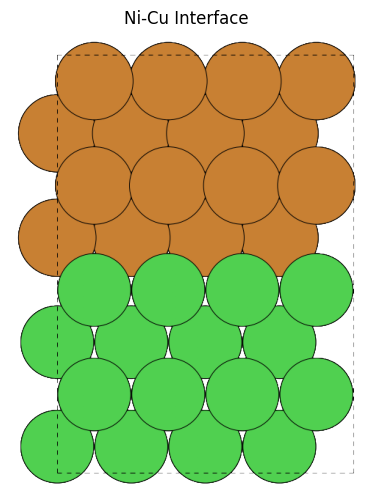

In [15]:
view_ase_atoms(cu_ni_interface, rotation="90x", figsize=(6, 6), scale=40, title="Ni-Cu Interface")

In [16]:
view_ngl(cu_ni_interface)

### 参考文献

 -  「機械・材料設計に生かす 実践分子動力学シミュレーション」 泉 聡志・増田裕寿